In [37]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as mae
%matplotlib inline

In [20]:
path = 'https://github.com/dataworkshop/5dwchallenge_2019/blob/master/challenge5/input/visits.csv?raw=true'
df = pd.read_csv(path, parse_dates=['published'], index_col='published')

In [21]:
df.dtypes

post_id    int64
dtype: object

In [22]:
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134137 entries, 2008-01-01 18:19:00 to 2016-10-31 23:56:00
Data columns (total 1 columns):
post_id    134137 non-null int64
dtypes: int64(1)
memory usage: 2.0 MB


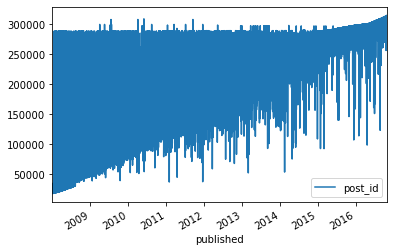

In [24]:
df.plot();

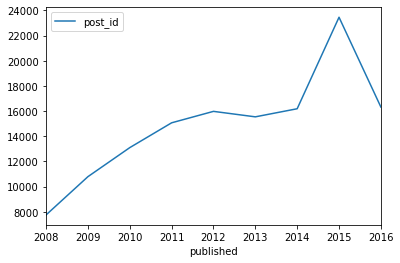

In [39]:
df.resample('1y').count().plot();

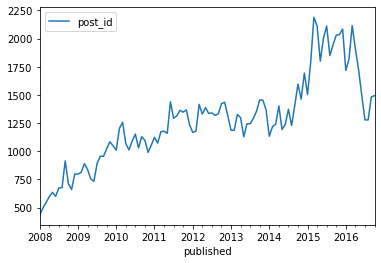

In [40]:
df.resample('1m').count().plot();

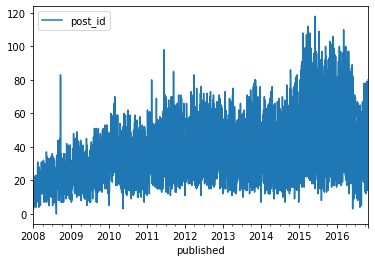

In [41]:
df.resample('1d').count().plot();

In [63]:
df_day = df.resample('1d').count().reset_index()
df_day.columns = ['ds', 'y']

df_day

,ds,y
0,2008-01-01,3
1,2008-01-02,3
2,2008-01-03,4
3,2008-01-04,14
4,2008-01-05,4
...,...,...
3222,2016-10-27,58
3223,2016-10-28,53
3224,2016-10-29,14
3225,2016-10-30,27


In [97]:
num_points_to_pred = 30

train = df_day[:-num_points_to_pred]
test = df_day[-num_points_to_pred:]

In [96]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [66]:
future = model.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=True)
future

,ds
0,2008-01-01
1,2008-01-02
2,2008-01-03
3,2008-01-04
4,2008-01-05
...,...
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30


In [67]:
forecast = model.predict(future)

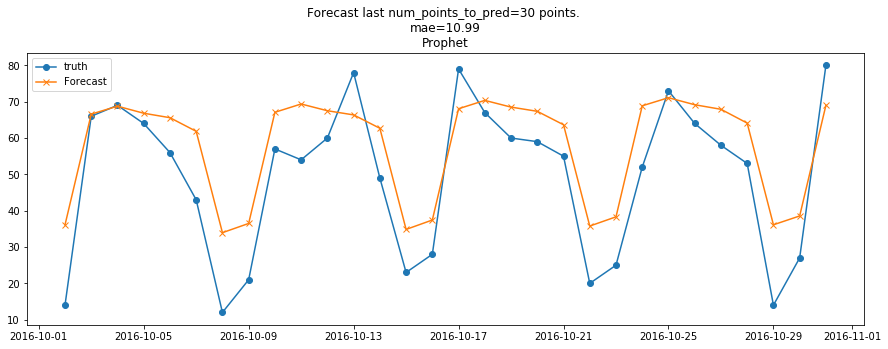

In [68]:
def plot_forecast(test, forecast):
    forecast = forecast[-num_points_to_pred:]
    score = np.round(mae(test.y, forecast.yhat),2)
    
    plt.figure(figsize=(15, 5))
    plt.title('Forecast last num_points_to_pred={} points. \nmae={}\nProphet'.format(num_points_to_pred, score))
    plt.plot(test.ds, test.y, 'o-', label='truth');
    plt.plot(test.ds, forecast.yhat, 'x-', label='Forecast')
    plt.legend()
    

plot_forecast(test, forecast)

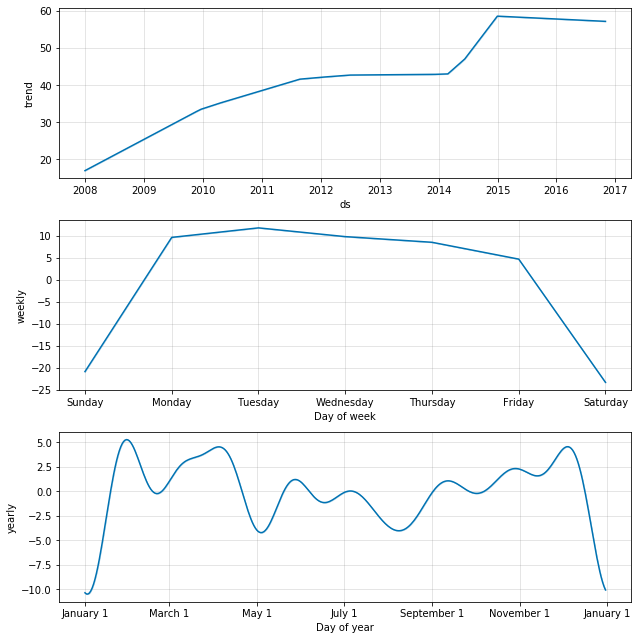

In [69]:
model.plot_components(forecast);

In [71]:
len(train), len(test)

(3197, 30)

In [73]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 67 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-09-01 00:00:00


In [75]:
df_cv.shape

(2010, 6)

In [76]:
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-11-11,30,30,30,30,30
2014-11-21,30,30,30,30,30
2014-12-01,30,30,30,30,30
2014-12-11,30,30,30,30,30
2014-12-21,30,30,30,30,30
...,...,...,...,...,...
2016-07-23,30,30,30,30,30
2016-08-02,30,30,30,30,30
2016-08-12,30,30,30,30,30


In [77]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [78]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,3 days,370.880636,19.258261,16.290693,0.564985,0.422886
1,4 days,335.711357,18.322428,15.725948,0.435991,0.427861
2,5 days,347.337215,18.636985,15.837603,0.477355,0.447761
3,6 days,350.526290,18.722347,15.645785,0.460709,0.472637
4,7 days,378.171895,19.446642,16.192848,0.468657,0.442786
5,8 days,369.704813,19.227710,15.850465,0.437131,0.467662
6,9 days,360.750587,18.993435,15.729791,0.436257,0.462687
7,10 days,403.976353,20.099163,16.484744,0.472290,0.472637
8,11 days,417.601795,20.435308,16.723957,0.585816,0.447761
9,12 days,424.907083,20.613274,17.236055,0.588839,0.422886


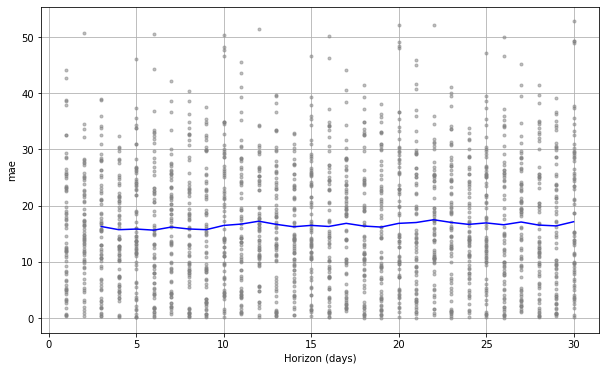

In [80]:
plot_cross_validation_metric(df_cv, 'mae');

In [98]:
num_points_to_pred = 30

train_log = train.copy()
train_log['y'] = np.log1p(train_log['y'])

In [100]:
model = Prophet(changepoint_prior_scale=0.01)
model.fit(train_log)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [101]:
future = model.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=False)
future

,ds
0,2016-10-02
1,2016-10-03
2,2016-10-04
3,2016-10-05
4,2016-10-06
5,2016-10-07
6,2016-10-08
7,2016-10-09
8,2016-10-10
9,2016-10-11


In [104]:
forecast = model.predict(future)
forecast['yhat'] = np.expm1(forecast.yhat)

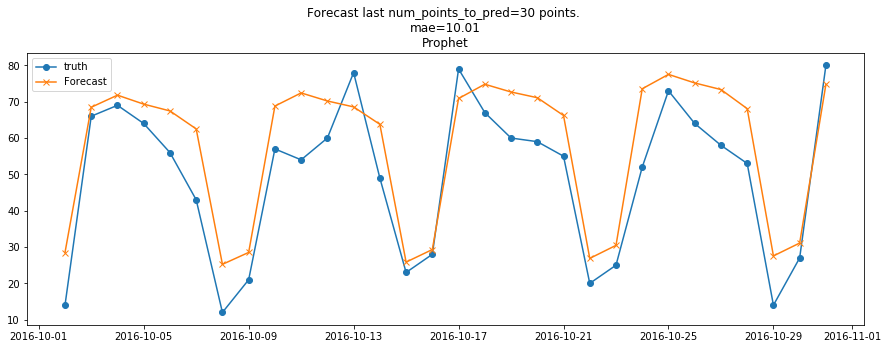

In [105]:
def plot_forecast(test, forecast):
    forecast = forecast[-num_points_to_pred:]
    score = np.round(mae(test.y, forecast.yhat),2)
    
    plt.figure(figsize=(15, 5))
    plt.title('Forecast last num_points_to_pred={} points. \nmae={}\nProphet'.format(num_points_to_pred, score))
    plt.plot(test.ds, test.y, 'o-', label='truth');
    plt.plot(test.ds, forecast.yhat, 'x-', label='Forecast')
    plt.legend()
    

plot_forecast(test, forecast)

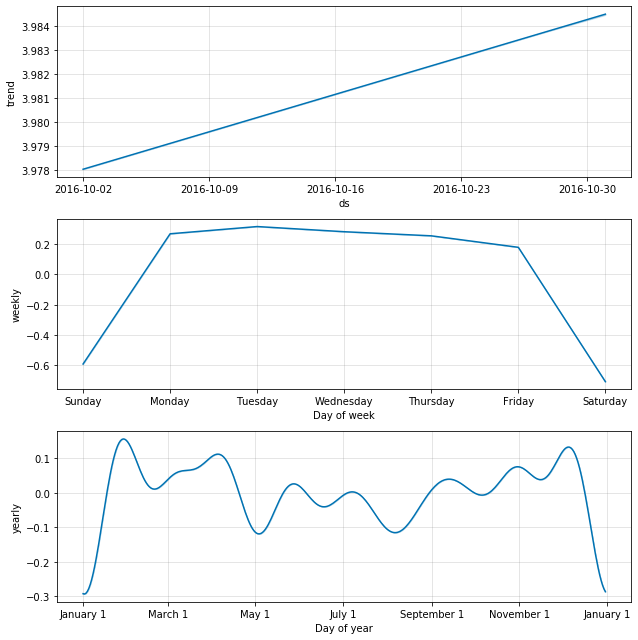

In [106]:
model.plot_components(forecast);

In [107]:
len(train), len(test)

(3197, 30)

In [108]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 67 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-09-01 00:00:00


In [109]:
df_cv.shape

(2010, 6)

In [110]:
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-11-11,30,30,30,30,30
2014-11-21,30,30,30,30,30
2014-12-01,30,30,30,30,30
2014-12-11,30,30,30,30,30
2014-12-21,30,30,30,30,30
...,...,...,...,...,...
2016-07-23,30,30,30,30,30
2016-08-02,30,30,30,30,30
2016-08-12,30,30,30,30,30


In [111]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [112]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,3 days,0.140716,0.375121,0.265269,0.080577,0.711443
1,4 days,0.089757,0.299596,0.237752,0.064094,0.756219
2,5 days,0.105941,0.325486,0.250977,0.070467,0.736318
3,6 days,0.107364,0.327664,0.251939,0.069972,0.756219
4,7 days,0.119095,0.345102,0.271823,0.075064,0.711443
5,8 days,0.107793,0.328318,0.265418,0.071294,0.706468
6,9 days,0.102830,0.320671,0.260682,0.070097,0.701493
7,10 days,0.115079,0.339233,0.268981,0.073559,0.706468
8,11 days,0.153722,0.392073,0.277373,0.084418,0.721393
9,12 days,0.154399,0.392937,0.278828,0.084371,0.731343


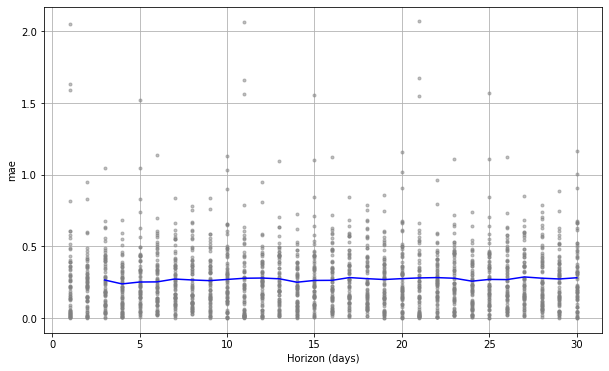

In [113]:
plot_cross_validation_metric(df_cv, 'mae');